In [84]:
import os
import json
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
# --------------------------------------------------------------------------------
# 1) Dateien & Verzeichnisse
# --------------------------------------------------------------------------------

EVAL_DIR = "evaluations"
CSV_FILE = "evaluations/final_temp.csv"

# Liste der Leader, die ausgewertet werden sollen (und für die es Evaluationsdaten gibt)
leaders_evaluated = ["OP01-001", "ST02-001", "ST13-003", "OP07-079", "OP08-098"]

In [86]:
# --------------------------------------------------------------------------------
# 2) Funktionen zum Laden / Zusammenführen der JSON
# --------------------------------------------------------------------------------

def load_all_trials_json(leader_id):
    """
    Lädt die Datei 'all_trials.json' zu einem bestimmten Leader, in der alle Trials
    (GNN Trial, Deck Trial) mitsamt Score, Synergy etc. abgelegt sind.
    
    Gibt ein pd.DataFrame zurück mit Spalten z. B.:
      - leader (str)
      - gnn_trial (int)
      - deck_trial (int)
      - deck (dict: card_id->anzahl)
      - score (float)
      - meta_overlap (int)
      - avg_synergy (float)
      - num_singletons (int)
    """
    # Pfad zur JSON
    path_json = os.path.join(EVAL_DIR, leader_id, "all_trials.json")
    if not os.path.exists(path_json):
        print(f"Datei nicht gefunden: {path_json}")
        return pd.DataFrame()

    with open(path_json, "r", encoding="utf-8") as f:
        data = json.load(f)  # Liste von { gnn_trial, deck_results: [...] }
    
    rows = []
    for trial_block in data:
        gnn_trial = trial_block["gnn_trial"]
        for deck_result in trial_block["deck_results"]:
            row = {
                "leader": leader_id,
                "gnn_trial": gnn_trial,
                "deck_trial": deck_result["deck_trial"],
                "deck": deck_result["deck"],  # Dictionary mit CardID -> Kopien
                "score": deck_result.get("score", np.nan),
                "meta_overlap": deck_result.get("meta_overlap", np.nan),
                "avg_synergy": deck_result.get("avg_synergy", np.nan),
                "num_singletons": deck_result.get("num_singletons", np.nan),
            }
            rows.append(row)

    return pd.DataFrame(rows)

In [67]:
# --------------------------------------------------------------------------------
# 3) Laden der JSON-Daten für alle Leader, Zusammenführen in ein zentrales DataFrame
# --------------------------------------------------------------------------------

df_list = []
for ld in leaders_evaluated:
    df_ld = load_all_trials_json(ld)
    df_list.append(df_ld)

df_evals = pd.concat(df_list, ignore_index=True)
# print("Eingelesene Daten aus all_trials.json:")
# print(f"-> {df_evals.shape[0]} Zeilen, {df_evals.shape[1]} Spalten\n")
df_evals.head()

,leader,gnn_trial,deck_trial,deck,score,meta_overlap,avg_synergy,num_singletons
0,OP01-001,1,1,"{'OP01-030': 2, 'OP01-120': 2, 'OP01-010': 1, ...",2853.559082,0,2.063501,5
1,OP01-001,1,2,"{'ST01-011': 2, 'ST01-004': 2, 'ST01-010': 2, ...",2815.091309,1,2.047359,5
2,OP01-001,1,3,"{'OP01-024': 1, 'OP01-004': 2, 'OP01-022': 2, ...",2837.621826,1,2.053221,5
3,OP01-001,1,4,"{'OP01-014': 2, 'OP01-022': 2, 'OP01-013': 2, ...",2853.666748,1,2.061460,5
4,OP01-001,1,5,"{'OP01-016': 2, 'OP01-006': 2, 'OP02-005': 3, ...",2840.410645,3,2.057597,5


In [68]:
# --------------------------------------------------------------------------------
# 4) Optional: Laden einer externen CSV (df_final_temp.csv) und Merge
# --------------------------------------------------------------------------------

if os.path.exists(CSV_FILE):
    df_csv = pd.read_csv(CSV_FILE)
    print(f"\nCSV '{CSV_FILE}' geladen: {df_csv.shape[0]} Zeilen, {df_csv.shape[1]} Spalten")
    df_merged = pd.merge(
        df_evals, 
        df_csv, 
        on=["leader","gnn_trial", "deck_trial"], 
        how="left"  # oder "inner"
    )
    print(f"\nNach Merge hat df_merged: {df_merged.shape[0]} Zeilen, {df_merged.shape[1]} Spalten")
else:
    print(f"CSV '{CSV_FILE}' nicht gefunden. Es wird nur df_evals benutzt.")
    df_merged = df_evals.copy()

CSV 'evaluations/final_temp.csv' nicht gefunden. Es wird nur df_evals benutzt.


In [69]:
df_merged.head()

,leader,gnn_trial,deck_trial,deck,score,meta_overlap,avg_synergy,num_singletons
0,OP01-001,1,1,"{'OP01-030': 2, 'OP01-120': 2, 'OP01-010': 1, ...",2853.559082,0,2.063501,5
1,OP01-001,1,2,"{'ST01-011': 2, 'ST01-004': 2, 'ST01-010': 2, ...",2815.091309,1,2.047359,5
2,OP01-001,1,3,"{'OP01-024': 1, 'OP01-004': 2, 'OP01-022': 2, ...",2837.621826,1,2.053221,5
3,OP01-001,1,4,"{'OP01-014': 2, 'OP01-022': 2, 'OP01-013': 2, ...",2853.666748,1,2.061460,5
4,OP01-001,1,5,"{'OP01-016': 2, 'OP01-006': 2, 'OP02-005': 3, ...",2840.410645,3,2.057597,5


In [70]:
# --------------------------------------------------------------------------------
# 5) Erste Auswertung: deskriptive Statistiken
# --------------------------------------------------------------------------------

df_analysis = df_merged.copy()
print("\n==== Basis-Statistiken (Scores) pro Leader ====")
stats_score = df_analysis.groupby("leader")["score"].describe()
print(stats_score)

print("\n==== Verteilung von 'avg_synergy' pro Leader ====")
stats_synergy = df_analysis.groupby("leader")["avg_synergy"].describe()
print(stats_synergy)


==== Basis-Statistiken (Scores) pro Leader ====
           count         mean         std          min          25%  \
leader                                                                
OP01-001  5000.0  3542.614992  835.453784  1378.026855  3429.828369   
OP07-079  5000.0  4020.627794  916.417622  1798.153442  3468.422974   
OP08-098  5000.0  2741.871736  498.446855   998.655884  2534.976562   
ST02-001  5000.0  2993.521822  738.179364  1171.397217  2623.720703   
ST13-003  5000.0  2936.864106  727.283671   568.514404  2746.909485   

                  50%          75%          max  
leader                                           
OP01-001  3744.445557  4131.174072  4829.105469  
OP07-079  4279.718018  4710.378906  5197.020996  
OP08-098  2919.773804  3086.703674  3310.768555  
ST02-001  3288.600220  3545.678406  3817.153809  
ST13-003  3105.371704  3404.007141  3994.910645  

==== Verteilung von 'avg_synergy' pro Leader ====
           count      mean       std       min      

In [71]:
stats_synergy.head()

,count,mean,std,min,25%,50%,75%,max
leader,,,,,,,,
OP01-001,5000.0,2.648854,0.705494,0.914646,2.504780,2.885268,3.091889,3.733522
OP07-079,5000.0,2.559113,0.607359,0.987925,2.085322,2.931277,3.035498,3.196242
OP08-098,5000.0,2.328871,0.427996,0.854625,2.139125,2.473820,2.632723,2.805426
ST02-001,5000.0,2.339288,0.612242,0.859761,2.010152,2.585045,2.786369,2.971559
ST13-003,5000.0,2.227817,0.604963,0.311729,1.986612,2.422358,2.658001,3.054866


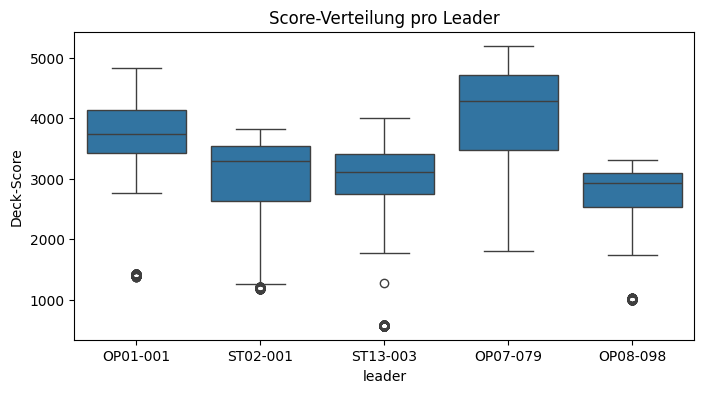

In [72]:
# --------------------------------------------------------------------------------
# 5.1) Visualisierung: Boxplot Score pro Leader
# --------------------------------------------------------------------------------

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_analysis, x="leader", y="score")
plt.title("Score-Verteilung pro Leader")
plt.ylabel("Deck-Score")
plt.show()

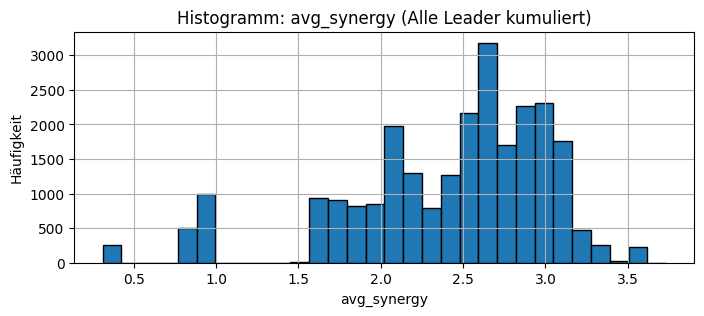

In [73]:
# --------------------------------------------------------------------------------
# 5.2) Visualisierung: Histogramm 'avg_synergy'
# --------------------------------------------------------------------------------

plt.figure(figsize=(8,3))
df_analysis["avg_synergy"].hist(bins=30, edgecolor="k")
plt.title("Histogramm: avg_synergy (Alle Leader kumuliert)")
plt.xlabel("avg_synergy")
plt.ylabel("Häufigkeit")
plt.show()

In [74]:
# --------------------------------------------------------------------------------
# 6) Auswertung Meta-Overlap
# --------------------------------------------------------------------------------

print("\n==== Verteilung von 'meta_overlap' pro Leader ====")
stats_overlap = df_analysis.groupby("leader")["meta_overlap"].describe()
print(stats_overlap)


==== Verteilung von 'meta_overlap' pro Leader ====
           count    mean       std  min  25%  50%  75%   max
leader                                                      
OP01-001  5000.0  3.8000  1.472153  0.0  3.0  4.0  5.0   9.0
OP07-079  5000.0  3.7654  1.327070  0.0  3.0  4.0  4.0   8.0
OP08-098  5000.0  5.6300  3.228558  0.0  3.0  5.0  9.0  10.0
ST02-001  5000.0  2.8012  1.839444  0.0  1.0  2.0  4.0  10.0
ST13-003  5000.0  3.4010  1.336921  0.0  4.0  4.0  4.0   7.0


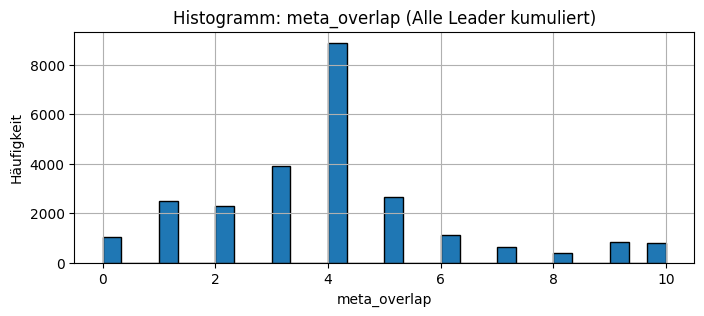

In [75]:
# add a fitting plot for the meta overlap
plt.figure(figsize=(8,3))
df_analysis["meta_overlap"].hist(bins=30, edgecolor="k")
plt.title("Histogramm: meta_overlap (Alle Leader kumuliert)")
plt.xlabel("meta_overlap")
plt.ylabel("Häufigkeit")
plt.show()


Korrelationsmatrix:
                   score  meta_overlap  avg_synergy  num_singletons
score           1.000000      0.119072     0.905983       -0.299682
meta_overlap    0.119072      1.000000     0.190070       -0.028505
avg_synergy     0.905983      0.190070     1.000000       -0.334926
num_singletons -0.299682     -0.028505    -0.334926        1.000000


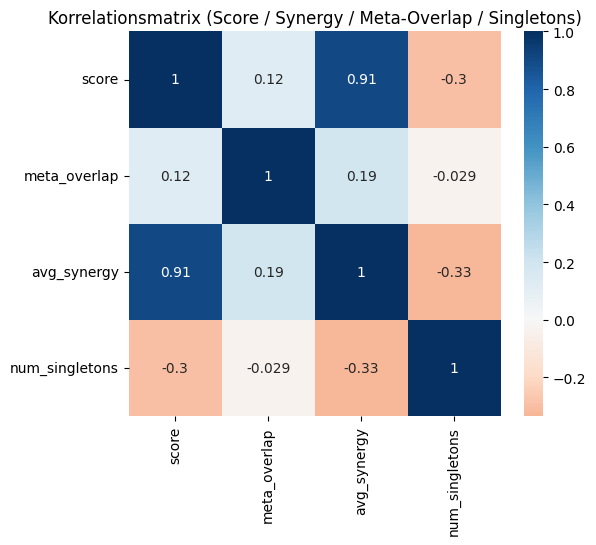

Korrelation (Score vs. avg_synergy) für Leader 'OP01-001': 0.991
Korrelation (Score vs. avg_synergy) für Leader 'ST02-001': 0.994
Korrelation (Score vs. avg_synergy) für Leader 'ST13-003': 0.989
Korrelation (Score vs. avg_synergy) für Leader 'OP07-079': 0.920
Korrelation (Score vs. avg_synergy) für Leader 'OP08-098': 0.998
Korrelation (Score vs. meta_overlap) für Leader 'OP01-001': 0.444
Korrelation (Score vs. meta_overlap) für Leader 'ST02-001': 0.390
Korrelation (Score vs. meta_overlap) für Leader 'ST13-003': 0.495
Korrelation (Score vs. meta_overlap) für Leader 'OP07-079': 0.410
Korrelation (Score vs. meta_overlap) für Leader 'OP08-098': -0.199
Korrelation (Score vs. num_singletons) für Leader 'OP01-001': -0.388
Korrelation (Score vs. num_singletons) für Leader 'ST02-001': -0.522
Korrelation (Score vs. num_singletons) für Leader 'ST13-003': -0.151
Korrelation (Score vs. num_singletons) für Leader 'OP07-079': -0.421
Korrelation (Score vs. num_singletons) für Leader 'OP08-098': -0.256

In [76]:
# --------------------------------------------------------------------------------
# 5.3) Korrelationen
# --------------------------------------------------------------------------------

corr_cols = ["score","meta_overlap","avg_synergy","num_singletons"]
corr_cols = [c for c in corr_cols if c in df_analysis.columns]  # Nur existierende
corr_matrix = df_analysis[corr_cols].corr()
print("\nKorrelationsmatrix:")
print(corr_matrix)

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu", center=0)
plt.title("Korrelationsmatrix (Score / Synergy / Meta-Overlap / Singletons)")
plt.show()

# calculate correlation between score and avg_synergy for each leader
for leader in leaders_evaluated:
    df_leader = df_analysis[df_analysis["leader"] == leader]
    corr = df_leader["score"].corr(df_leader["avg_synergy"])
    print(f"Korrelation (Score vs. avg_synergy) für Leader '{leader}': {corr:.3f}")

# calculate correlation between score and meta_overlap for each leader
for leader in leaders_evaluated:
    df_leader = df_analysis[df_analysis["leader"] == leader]
    corr = df_leader["score"].corr(df_leader["meta_overlap"])
    print(f"Korrelation (Score vs. meta_overlap) für Leader '{leader}': {corr:.3f}")

# calculate correlation between score and num_singletons for each leader
for leader in leaders_evaluated:
    df_leader = df_analysis[df_analysis["leader"] == leader]
    corr = df_leader["score"].corr(df_leader["num_singletons"])
    print(f"Korrelation (Score vs. num_singletons) für Leader '{leader}': {corr:.3f}")


Aggregationen auf Leader, gnn_trial-Ebene:
     leader  gnn_trial   score_mean   score_std    score_min    score_max  \
0  OP01-001          1  2827.200840   18.476005  2770.776367  2870.863525   
1  OP01-001          2  3641.587732   31.236039  3576.410889  3707.558594   
2  OP01-001          3  4322.173488   49.594973  4240.314453  4417.889648   
3  OP01-001          4  4139.423146   15.675461  4115.425293  4177.508789   
4  OP01-001          5  3635.925144   26.764131  3577.267334  3694.268799   
5  OP01-001          6  1410.872969    7.467871  1389.035278  1426.633789   
6  OP01-001          7  3928.043354   16.090940  3903.228760  3971.607666   
7  OP01-001          8  3968.431752   49.619427  3866.911865  4073.589844   
8  OP01-001          9  4031.301249  194.390656  3703.313965  4635.237305   
9  OP01-001         10  3613.168075   21.720693  3566.940186  3661.458252   

   synergy_mean  synergy_std  metaover_mean  metaover_std  
0      2.051742     0.006401          1.024     

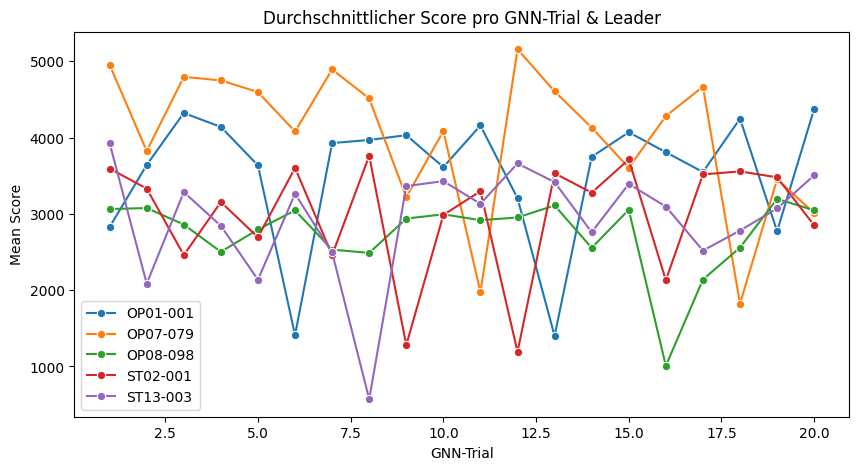

In [77]:
# --------------------------------------------------------------------------------
# 5.4) Gruppierung nach gnn_trial + leader
# --------------------------------------------------------------------------------

grouped_trial = df_analysis.groupby(["leader","gnn_trial"]).agg({
    "score":["mean","std","min","max"],
    "avg_synergy":["mean","std"],
    "meta_overlap":["mean","std"]
}).reset_index()
grouped_trial.columns = [
    "leader","gnn_trial",
    "score_mean","score_std","score_min","score_max",
    "synergy_mean","synergy_std",
    "metaover_mean","metaover_std"
]
print("\nAggregationen auf Leader, gnn_trial-Ebene:")
print(grouped_trial.head(10))

# Beispiel: Liniendiagramm Score_mean über gnn_trial
plt.figure(figsize=(10,5))
sns.lineplot(data=grouped_trial, x="gnn_trial", y="score_mean", hue="leader", marker="o")
plt.title("Durchschnittlicher Score pro GNN-Trial & Leader")
plt.xlabel("GNN-Trial")
plt.ylabel("Mean Score")
plt.legend()
plt.show()

In [78]:
# --------------------------------------------------------------------------------
# 6) Deck-spezifische Analysen
# --------------------------------------------------------------------------------

def count_cards(deck_series):
    """
    Summiert die Auftrittshäufigkeit einzelner CardIDs in allen
    Deck-Dicts einer Series.
    """
    c_all = Counter()
    for deck_dict in deck_series.dropna():
        if isinstance(deck_dict, dict):
            for cid, cnt in deck_dict.items():
                c_all[cid] += cnt
    return c_all

print("\n=== Häufigste Karten pro Leader (über alle Trials und Decks) ===")
for ld in leaders_evaluated:
    df_ld = df_analysis[df_analysis["leader"]==ld]
    ccount = count_cards(df_ld["deck"])
    if len(ccount)==0:
        print(f" -> Leader {ld}: Keine Deck-Daten?")
        continue
    
    top10 = ccount.most_common(10)
    print(f"\nLeader {ld}: Top 10 Karten [CardID -> Anzahl Kopien]")
    for cardid, amount in top10:
        print(f"  {cardid}: {amount}")


=== Häufigste Karten pro Leader (über alle Trials und Decks) ===

Leader OP01-001: Top 10 Karten [CardID -> Anzahl Kopien]
  OP01-030: 12275
  OP01-016: 11918
  OP03-008: 11819
  OP02-018: 11678
  P-014: 10810
  OP03-003: 10656
  OP03-013: 10618
  OP05-004: 10556
  OP05-017: 10535
  OP05-018: 10513

Leader ST02-001: Top 10 Karten [CardID -> Anzahl Kopien]
  OP01-044: 12295
  OP01-049: 12286
  OP01-050: 12256
  OP01-051: 12145
  ST02-005: 11377
  ST02-017: 11342
  OP02-035: 10556
  OP02-036: 10303
  OP02-030: 9003
  OP03-029: 8938

Leader ST13-003: Top 10 Karten [CardID -> Anzahl Kopien]
  OP03-108: 13316
  OP04-104: 13262
  OP05-101: 13226
  ST07-007: 13212
  OP05-105: 13136
  OP03-116: 13079
  OP06-086: 12514
  ST13-010: 12469
  ST13-007: 12431
  OP06-104: 12427

Leader OP07-079: Top 10 Karten [CardID -> Anzahl Kopien]
  OP06-086: 13103
  OP05-091: 13081
  OP03-089: 12955
  OP03-086: 12933
  OP03-090: 12877
  OP02-113: 12793
  OP02-099: 12034
  OP03-094: 11997
  OP04-081: 8623
  OP05


Einige Zeilen mit deck_size, deck_diversity:
     leader  gnn_trial  deck_trial  deck_size  deck_diversity
0  OP01-001          1           1         50              25
1  OP01-001          1           2         50              24
2  OP01-001          1           3         50              24
3  OP01-001          1           4         50              27
4  OP01-001          1           5         50              24
5  OP01-001          1           6         50              22
6  OP01-001          1           7         50              23
7  OP01-001          1           8         50              24
8  OP01-001          1           9         50              25
9  OP01-001          1          10         50              24


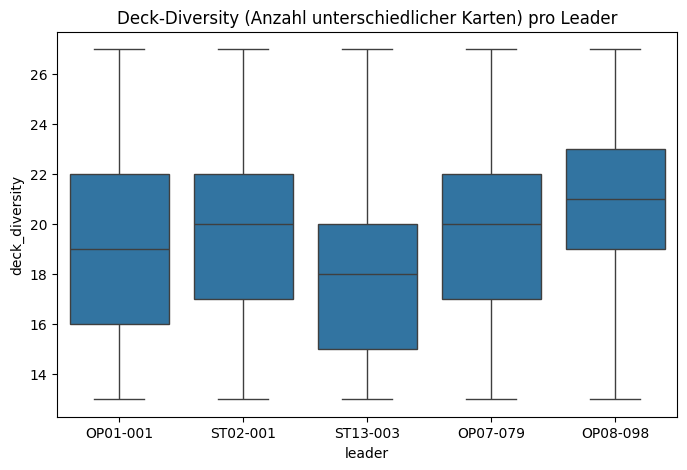

In [79]:
def deck_size_and_diversity(row):
    """
    Gibt (size, diversity) zurück:
      size = Summe der Kopien
      diversity = Anzahl unterschiedlicher Karten
    """
    d = row["deck"]
    if not isinstance(d, dict):
        return pd.Series([np.nan, np.nan])
    total_copies = sum(d.values())
    diff_cards = len(d.keys())
    return pd.Series([total_copies, diff_cards])

df_analysis[["deck_size","deck_diversity"]] = df_analysis.apply(deck_size_and_diversity, axis=1)

print("\nEinige Zeilen mit deck_size, deck_diversity:")
print(df_analysis[["leader","gnn_trial","deck_trial","deck_size","deck_diversity"]].head(10))

# Boxplot deck_diversity pro Leader
plt.figure(figsize=(8,5))
sns.boxplot(data=df_analysis, x="leader", y="deck_diversity")
plt.title("Deck-Diversity (Anzahl unterschiedlicher Karten) pro Leader")
plt.show()


In [ ]:
# Deckliste mit dem höchsten Score pro Leader
def best_deck_per_leader(df):
    """
    Gibt für jeden Leader das Deck mit dem höchsten Score zurück.
    """
    idx = df.groupby("leader")["score"].transform(max) == df["score"]
    return df[idx]


df_best_decks = best_deck_per_leader(df_analysis)

print("\n=== Bestes Deck pro Leader ===")
# the deck is a dict containing the card_id as key and the amount of copies as value. Print the list as {count}x {card_name}
for idx, row in df_best_decks.iterrows():
    leader = row["leader"]
    gnn_trial = row["gnn_trial"]
    deck_trial = row["deck_trial"]
    deck = row["deck"]
    score = row["score"]
    print(f"Leader '{leader}' (GNN-Trial {gnn_trial}, Deck-Trial {deck_trial}): Score {score}")
    print(deck)
    for card_id, count in deck.items():
        print(f"  {count}x {card_id}")
    print()


=== Bestes Deck pro Leader ===
Leader 'OP01-001' (GNN-Trial 16, Deck-Trial 21): Score 4829.10546875
{'OP01-006': 4, 'OP01-029': 3, 'OP01-022': 3, 'OP01-017': 3, 'OP01-013': 2, 'OP01-120': 2, 'OP01-025': 4, 'ST01-012': 3, 'ST01-011': 3, 'ST01-015': 3, 'OP02-011': 3, 'OP02-008': 1, 'OP02-015': 3, 'P-013': 3, 'P-019': 1, 'OP03-018': 3, 'OP03-020': 3, 'OP04-016': 3}
  4x OP01-006
  3x OP01-029
  3x OP01-022
  3x OP01-017
  2x OP01-013
  2x OP01-120
  4x OP01-025
  3x ST01-012
  3x ST01-011
  3x ST01-015
  3x OP02-011
  1x OP02-008
  3x OP02-015
  3x P-013
  1x P-019
  3x OP03-018
  3x OP03-020
  3x OP04-016

Leader 'ST02-001' (GNN-Trial 8, Deck-Trial 36): Score 3817.15380859375
{'OP01-037': 2, 'OP01-050': 2, 'OP01-044': 2, 'OP01-040': 2, 'OP01-049': 2, 'OP01-051': 2, 'ST02-005': 3, 'ST02-017': 3, 'ST02-007': 2, 'OP02-037': 2, 'OP02-035': 4, 'OP02-041': 3, 'OP02-036': 2, 'OP02-030': 1, 'OP02-044': 2, 'OP03-030': 2, 'OP03-027': 1, 'OP03-029': 2, 'OP04-119': 2, 'OP05-033': 1, 'ST12-003': 3, 

C:\Users\sandr\AppData\Local\Temp\ipykernel_1336\3948551135.py:6: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = df.groupby("leader")["score"].transform(max) == df["score"]
